This notebook implements supervised weights for approximating the solution to the one-dimensional Gross-Pitavskii equation.

# Import Libraries

In [1]:
%%capture
!pip install pytorch-optimizer
!git clone https://github.com/facebookresearch/optimizers.git
%cd optimizers
!pip install .
%cd ..

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import os
from torch.autograd import grad
from scipy.special import hermite
# from adabelief_pytorch import AdaBelief
from pytorch_optimizer import QHAdam, AdaHessian, Ranger21, SophiaH, Shampoo
from distributed_shampoo import AdamGraftingConfig, DistributedShampoo, DefaultEigenvalueCorrectedShampooConfig
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.utils
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [3]:
class GrossPitaevskiiPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, g=100.0, mode=0, beta_init=1.0, alpha_init=1.0, decay_rate=0.001):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        g : float, optional
            Interaction strength (default is 100.0).
        mode : int, optional
            Mode number (default is 0).
        beta_init : float, optional
            Initial weight for previous predictions, default is 1.0.
        alpha_init : float, optional
            Initial weight for learned perturbations, default is 1.0.
        decay_rate : float, optional
            Rate at which beta decays over time, default is 0.001.
        """
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.g = g  # Interaction strength
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed
        self.mode = mode  # Mode number (n)
        self.beta = beta_init
        self.alpha = alpha_init
        self.decay_rate = decay_rate
        self.iteration = 0

    def update_alpha_beta(self):
        """
        Updates the weighting factors alpha and beta adaptively.
        """
        self.iteration += 1
        self.beta = max(0.1, self.beta * torch.exp(torch.tensor(-self.decay_rate * self.iteration)))
        self.alpha = 1.0 + (1.0 - self.beta)  # Makes α increase as β decreases

    def build_network(self):
        """
        Build the neural network with sine activation functions between layers.

        Returns
        -------
        nn.Sequential
            A PyTorch sequential model representing the neural network architecture.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def weighted_hermite(self, x, n):
        """
        Compute the weighted Hermite polynomial solution for the linear case (gamma = 0).
        Equation (34) in https://www.sciencedirect.com/science/article/abs/pii/S0010465513001318.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates (collocation points) or boundary points.
        n : int
            Mode of ground state solution to Gross-Pitavskii equation (0 for base ground state)

        Returns
        -------
        torch.Tensor
            The weighted Hermite polynomial solution for the linear case (gamma = 0).
        """
        H_n = hermite(n)(x.cpu().detach().numpy())  # Hermite polynomial evaluated at x
        norm_factor = (2**n * math.factorial(n) * np.sqrt(np.pi))**(-0.5)
        weighted_hermite = norm_factor * torch.exp(-x**2 / 2) * torch.tensor(H_n, dtype=torch.float32).to(device)

        return weighted_hermite

    def forward(self, inputs):
        """
        Forward pass through the neural network.
        """
        return self.network(inputs)

    def compute_potential(self, x, potential_type="harmonic", **kwargs):
        """
        Compute a symmetric or asymmetric potential function for the 1D domain.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of spatial coordinates.
        potential_type : str, optional
            Type of potential. Options are: "harmonic".
        kwargs : dict
            Additional parameters specific to each potential type.

        Returns
        -------
        V : torch.Tensor
            Tensor of potential values at the input points.

        Raises
        ------
        ValueError
            If the potential type is not recognized.
        """
        if potential_type == "harmonic":
            omega = kwargs.get('omega', 1.0)  # Frequency for harmonic potential
            V = 0.5 * omega ** 2 * x ** 2
        elif potential_type == "gaussian":
            a = kwargs.get('a', 0.0)  # Center of the Gaussian
            V = torch.exp(-(x - a) ** 2)
        elif potential_type == "periodic":
            V0 = kwargs.get('V0', 1.0)  # Depth of the potential
            k = kwargs.get('k', 2 * np.pi / 5.0)  # Wave number for periodic potential
            V = V0 * torch.cos(k * x) ** 2
        else:
            raise ValueError(f"Unknown potential type: {potential_type}")

        return V

    def compute_thomas_fermi_approx(self, lambda_pde, potential, eta):
        """
        Calculate the Thomas–Fermi approximation for the given potential.

        Parameters
        ----------
        lambda_pde : float
            Eigenvalue from lowest energy ground state.
        potential : torch.Tensor
            Potential values corresponding to the spatial coordinates.
        eta : float
            Interaction strength.

        Returns
        -------
        torch.Tensor
            Thomas–Fermi approximation of the wave function.
        """
        # For eta = 0, return None (TF approximation not valid)
        if eta == 0:
            return None

        # Calculate TF approximation: ψ_TF(x) = sqrt(max(0, (λ - V(x))/η))
        # tf_approx = torch.sqrt(torch.relu((lambda_pde - potential) / eta))
        tf_approx = torch.sqrt((lambda_pde - potential) / eta)

        return tf_approx

    def get_complete_solution(self, x, perturbation, prev_prediction=None, mode=0):
        """
        Combine the weighted Hermite approximation and the learned perturbation.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of spatial coordinates.
        perturbation : torch.Tensor
            The perturbation predicted by the neural network.
        prev_prediction : callable, optional
            Previously trained model's prediction function.
        mode: int
            Mode of ground state solution to Gross-Pitavskii equation. Default is 0.

        Returns:
        --------
        torch.Tensor
            The complete wave function solution.
        """
        base_solution = self.weighted_hermite(x, mode)

        if prev_prediction is None:
            complete_solution = base_solution + self.alpha * perturbation
        else:
            prev_solution = prev_prediction(x)
            complete_solution = self.beta * prev_solution + self.alpha * perturbation

        norm = torch.norm(complete_solution, 2)
        normalization_factor = 1.0 / (norm + 0.1)  # Softened normalization

        return complete_solution #* normalization_factor

    def boundary_loss(self, boundary_points, boundary_values, prev_prediction=None, mode=0):
        """
        Compute the boundary loss (MSE) for the boundary conditions.

        Parameters
        ----------
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.
        mode: int
            Mode of ground state solution to Gross-Pitavskii equation. Default is 0.

        Returns
        -------
        torch.Tensor
            Mean squared error (MSE) at the boundary points.
        """
        u_pred = self.forward(boundary_points)
        u = self.get_complete_solution(boundary_points, u_pred, prev_prediction, mode)

        return torch.mean((u - boundary_values) ** 2)

    def riesz_loss(self, predictions, inputs, eta, potential_type, precomputed_potential=None, prev_prediction=None, mode=0):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        predictions : torch.Tensor
            Predicted solution from the network.
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        eta : float
            Interaction strength.
        potential_type : str
            Type of potential function to use.
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.
        mode: int
            Mode of ground state solution to Gross-Pitavskii equation. Default is 0.

        Returns
        -------
        torch.Tensor
            Riesz energy loss value.
        """

        u = self.get_complete_solution(inputs, predictions, prev_prediction, mode)

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        u_x = torch.autograd.grad(outputs=u, inputs=inputs,
                                  grad_outputs=torch.ones_like(predictions),
                                  create_graph=True, retain_graph=True)[0]

        laplacian_term = torch.mean(u_x ** 2)  # Kinetic term
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        potential_term = torch.mean(V * u ** 2)  # Potential term
        interaction_term = 0.5 * eta * torch.mean(u ** 4)  # Interaction term

        riesz_energy = 0.5 * (laplacian_term + potential_term + interaction_term)
        return riesz_energy

    def pde_loss(self, inputs, predictions, eta, potential_type, precomputed_potential=None, prev_prediction=None, mode=0):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.

        Parameters
        ----------
        inputs : torch.Tensor
            Input tensor of spatial coordinates (collocation points).
        predictions : torch.Tensor
            Predicted solution from the network.
        eta : float
            Interaction strength.
        potential_type : str
            Type of potential function to use.
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch.
        mode: int
            Mode of ground state solution to Gross-Pitavskii equation. Default is 0.

        Returns
        -------
        tuple
            Tuple containing:
                - torch.Tensor: PDE loss value.
                - torch.Tensor: PDE residual.
                - torch.Tensor: Smallest eigenvalue (lambda).
        """
        u = self.get_complete_solution(inputs, predictions, prev_prediction, mode)

        # Compute first and second derivatives with respect to x
        u_x = grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        # Compute λ from the energy functional
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        lambda_pde = torch.mean(u_x ** 2 + V * u ** 2 + eta * u ** 4) / torch.mean(u ** 2)

        # Residual of the 1D Gross-Pitaevskii equation
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(inputs, potential_type)
        pde_residual = -u_xx + V * u + eta * torch.abs(u ** 2) * u - lambda_pde * u

        # Regularization: See https://arxiv.org/abs/2010.05075

        # Term 1: L_f = 1 / (f(x, λ))^2, penalizes the network if the PDE residual is close to zero to avoid trivial eigenfunctions
        L_f = 1 / (torch.mean(u ** 2) + 1e-2)

        # Term 2: L_λ = 1 / λ^2, penalizes small eigenvalues λ, ensuring non-trivial eigenvalues
        L_lambda = 1 / (lambda_pde ** 2 + 1e-6)

        # Term 3: L_drive = e^(-λ + c), encourages λ to grow, preventing collapse to small values
        L_drive = torch.exp(-lambda_pde + 1.0)

        # PDE loss (residual plus regularization terms)
        pde_loss = torch.mean(pde_residual ** 2)  #+ L_lambda + L_f

        return pde_loss, pde_residual, lambda_pde

    def symmetry_loss(self, collocation_points, lb, ub):
        """
        Compute the symmetry loss to enforce u(x) = u((a+b)-x).

        Parameters
        ----------
        collocation_points : torch.Tensor
            Tensor of interior spatial points.
        lb : torch.Tensor
            Lower bound of interval.
        ub: torch.Tensor
            Upper bound of interval.

        Returns
        -------
        sym_loss : torch.Tensor
            The mean squared error enforcing symmetry u(x) = u((a+b)-x).
        """
        # Reflect points across the center of the domain
        x_reflected = (lb + ub) - collocation_points

        # Evaluate u(x) and u((a+b)-x)
        u_original = self.forward(collocation_points)
        u_reflected = self.forward(x_reflected)

        # Compute MSE to enforce symmetry
        sym_loss = torch.mean((u_original - u_reflected) ** 2)
        return sym_loss

    def total_loss(self, collocation_points, boundary_points, boundary_values, eta, lb, ub, weights, potential_type,
                   precomputed_potential=None, prev_prediction=None, mode=0):
        """
        Compute the total loss combining boundary loss, Riesz energy loss,
        PDE loss, L^2 norm regularization loss, and symmetry loss.

        Parameters
        ----------
        collocation_points : torch.Tensor
            Input tensor of spatial coordinates for the interior points.
        boundary_points : torch.Tensor
            Input tensor of boundary spatial points.
        boundary_values : torch.Tensor
            Tensor of boundary values (for Dirichlet conditions).
        eta : float
            Interaction strength.
        lb : torch.Tensor
            Lower bound of interval.
        ub : torch.Tensor
            Upper bound of interval.
        weights : list
            Weights for different loss terms.
        potential_type : str
            Type of potential function to use
        precomputed_potential : torch.Tensor
            Precomputed potential. Default is None.
        prev_prediction : GrossPitaevskiiPINN or None
            Previously trained model whose predictions are used as part of the training process.
            If None, the model starts training from scratch. Default is None.
        mode: int
            Mode of ground state solution to Gross-Pitavskii equation. Default is 0.

        Returns
        -------
        total_loss : torch.Tensor
            Total loss value.
        """

        # Use precomputed potential if provided
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(collocation_points, potential_type)

        # Compute individual loss components
        data_loss = self.boundary_loss(boundary_points, boundary_values, prev_prediction, mode)
        riesz_energy_loss = self.riesz_loss(self.forward(collocation_points), collocation_points, eta, potential_type,
                                            V, prev_prediction, mode)
        pde_loss, _, _ = self.pde_loss(collocation_points, self.forward(collocation_points), eta, potential_type,
                                            V, prev_prediction, mode)
        norm_loss = (torch.norm(self.forward(collocation_points), p=2) - 1) ** 2
        sym_loss = self.symmetry_loss(collocation_points, lb, ub)

        # Scaling factor for pde loss and riesz energy loss
        domain_length = ub - lb

        # Compute weighted losses and total loss
        losses = [data_loss, riesz_energy_loss  / domain_length, pde_loss / domain_length, norm_loss, sym_loss]
        weighted_losses = [weights[i] * loss for i, loss in enumerate(losses)]
        total_loss = sum(weighted_losses)

        # Add regularization term to encourage wider solutions for higher eta
        width_penalty = -eta * torch.mean(collocation_points ** 2 * torch.abs(self.forward(collocation_points)) ** 2)

        # total_loss = data_loss + (pde_loss / domain_length) + (riesz_energy_loss  / domain_length) #+ 0.01 * width_penalty

        if mode == 0:
            total_loss = data_loss + (pde_loss / domain_length) + (riesz_energy_loss / domain_length) + 100 * norm_loss
        else:
            total_loss = data_loss + (pde_loss / domain_length) + 100 * norm_loss

        return total_loss, data_loss, riesz_energy_loss, pde_loss, norm_loss

# Initialize Weights

In [4]:
def initialize_weights(m):
    """
    Initialize the weights of the neural network layers using Xavier uniform initialization.

    Parameters
    ----------
    m : torch.nn.Module
        A layer of the neural network. If it is a linear layer, its weights and biases are initialized.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Prepare Training Data

In [5]:
def prepare_training_data(N_u, N_f, lb, ub):
    """
    Prepare boundary and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points.
    lb : np.ndarray
        Lower bounds of the domain.
    ub : np.ndarray
        Upper bounds of the domain.

    Returns
    -------
    collocation_points : np.ndarray
        Collocation points.
    boundary_points : np.ndarray
        Boundary points.
    boundary_values : np.ndarray
        Boundary values.
    """

    # Boundary of interval
    boundary_points = np.array([[lb], [ub]])
    boundary_values = np.zeros((2, 1))

    # Dynamically sample points inside the interval
    collocation_points = np.random.rand(N_f, 1) * (ub - lb) + lb

    return collocation_points, boundary_points, boundary_values

# Train PINN with Optimizer

In [6]:
def train_pinn_with_optimizer(model, X, N_u, N_f, layers, eta, epochs, lb, ub, weights, model_save_path, potential_type,
                              prev_prediction, optimizer_name, mode):
    """
    Train the Physics-Informed Neural Network (PINN) for the 1D Gross-Pitaevskii equation.

    Parameters
    ----------
    model : GrossPitaevskiiPINN
        The initialized PINN model to be trained.
    X : np.ndarray
        Input data for the neural network
    N_u : int
        Number of boundary points
    N_f : int
        Number of collocation points (interior points) for the physics-based loss
    layers : list of int
        Architecture of the neural network
    eta : float
        Interaction strength
    epochs: int
        Number of epochs
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    weights : list
        Weights for different loss terms.
    model_save_path : str
        Save path for trained model
    potential_type: str
        Type of potential function to use
    prev_prediction : GrossPitaevskiiPINN or None
        Previously trained model whose predictions are used as part of the training process.
        If None, the model starts training from scratch.
    optimizer_name : str
        Name of optimizer to train.
    mode: int
        Mode of ground state solution to Gross-Pitavskii equation.

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained model
    loss_history : list of float
        List of loss values recorded during training for the specific optimizer.
    lambda_pde_history : list of float
        List of λ_PDE values recorded during training for the specific optimizer.
    """

    # Select the optimizer
    optimizers = {
        "Adam": optim.Adam(model.parameters(), lr=1e-3),
        # "Adam": optim.Adam(model.parameters(), lr=5e-3),
        "AdamW": optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.99)),
        "Shampoo": DistributedShampoo( model.parameters(),
                                       lr=0.001,
                                       betas=(0.9, 0.999),
                                       epsilon=1e-12,
                                       weight_decay=1e-05,
                                       max_preconditioner_dim=8192,
                                       start_preconditioning_step=100,
                                       precondition_frequency=100,
                                       use_decoupled_weight_decay=False,
                                       grafting_config=AdamGraftingConfig(beta2=0.999,epsilon=1e-08),
                                       )

    }

    optimizer = optimizers[optimizer_name]
    # scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=epochs // 10, epochs=epochs)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, factor=0.5, verbose=True)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs // 10, eta_min=1e-5)

    # Prepare training data (collocation and boundary points)
    collocation_points, boundary_points, boundary_values = prepare_training_data(N_u, N_f, lb, ub)

    # Convert data to PyTorch tensors and move to device
    collocation_points_tensor = torch.tensor(collocation_points, dtype=torch.float32, requires_grad=True).to(device)
    boundary_points_tensor = torch.tensor(boundary_points, dtype=torch.float32).to(device)
    boundary_values_tensor = torch.tensor(boundary_values, dtype=torch.float32).to(device)
    lb_tensor = torch.tensor(lb, dtype=torch.float32).to(device)
    ub_tensor = torch.tensor(ub, dtype=torch.float32).to(device)

    # Precompute potential
    V = model.compute_potential(collocation_points_tensor, potential_type).detach()
    V.requires_grad = False

    # Precompute Thomas-Fermi approximation
    #tf_approx = model.compute_thomas_fermi_approx(collocation_points_tensor, V, eta).detach()
    #tf_approx.requires_grad = False

    loss_history = []
    lambda_pde_history = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Calculate the total loss (boundary, Riesz energy, PDE, normalization, and symmetry losses)
        # with precomputed potential and Thomas-Fermi approximation
        model.update_alpha_beta()
        loss, data_loss, riesz_energy, pde_loss, norm_loss = model.total_loss(collocation_points_tensor,
                                                                              boundary_points_tensor,
                                                                              boundary_values_tensor,
                                                                              eta,
                                                                              lb_tensor, ub_tensor,
                                                                              weights, potential_type, V,
                                                                              prev_prediction, mode)

        # Backpropagation and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()
        scheduler.step(loss)

        # Record the total loss and lambda_pde every 100 epochs
        if epoch % 100 == 0:
            _, _, lambda_pde = model.pde_loss(
                collocation_points_tensor, model.forward(collocation_points_tensor),
                eta, potential_type, V, prev_prediction
            )
            loss_history.append(loss.item())
            lambda_pde_history.append(lambda_pde.detach().cpu().item())

        # Compute λ_PDE, η, and loss every 1,000 epochs
        if epoch % 1000 == 0:
            _, _, lambda_pde = model.pde_loss(
                collocation_points_tensor, model.forward(collocation_points_tensor),
                eta, potential_type, V, prev_prediction
            )
            print(f"[{optimizer_name}] Epoch [{epoch}/{epochs}]: η = {eta}, λ_PDE = {lambda_pde.item():.6f}, Loss: {loss.item():.6f}")

    return model, loss_history, lambda_pde_history

# Normalize Wave Function


In [7]:
def normalize_wave_function(u):
    """
    Normalize the wave function with respect to its maximum value.

    Parameters
    ----------
    u : torch.Tensor
        The predicted wave function.

    Returns
    -------
    torch.Tensor
        The normalized wave function.
    """
    return np.abs(u) / np.max(np.abs(u))

# Plot Potential

In [8]:
def plot_potential_1D(X_test, potential):
    """
    Plot the 1D potential function.

    Parameters
    ----------
    X_test : np.ndarray
        The test points where the potential is computed.
    potential : np.ndarray
        The computed potential values at the test points.
    """
    plt.figure(figsize=(6, 5))

    # X_test is the x-values (positions) of the 1D potential
    plt.plot(X_test, potential, label='Potential $V(x)$', color='green')

    plt.title('Potential $V(x)$ in 1D')
    plt.xlabel('$x$')
    plt.ylabel('$V(x)$')
    plt.grid(True)
    plt.legend()
    plt.show()

# Train and Save PINN

In [9]:
def train_and_save_pinn(X, N_u, N_f, layers, eta, epochs, lb, ub, weights, model_save_path, potential_type,
                        prev_model, optimizer_name, mode):
    """
    Train the Physics-Informed Neural Network (PINN) model and save it.

    This function trains a PINN model for the 1D Gross-Pitaevskii equation with a specific interaction
    strength (eta) and saves the trained model to a specified path. It also returns the trained model
    and the loss history recorded during training.

    Parameters
    ----------
    X : np.ndarray
        Input data for the training (e.g., spatial domain points).
    N_u : int
        Number of boundary points.
    N_f : int
        Number of collocation points (interior points) for physics-based loss.
    layers : list of int
        Architecture of the neural network, defined as a list of layer sizes.
        For example, [1, 100, 100, 100, 1] represents an input layer with 1 neuron,
        three hidden layers with 20 neurons each, and an output layer with 1 neuron.
    eta : float
        Interaction strength parameter for the Gross-Pitaevskii equation.
    epochs : int
        Number of training epochs.
    lb : int
        Lower bound of interval.
    ub : int
        Upper bound of interval.
    weights : list
        Weights for different loss terms.
    model_save_path : str
        File name to save the trained model weights (e.g., 'model_eta_1.pth').
    potential_type: str
        Type of potential function to use
    prev_model : GrossPitaevskiiPINN or None
        Previously trained model whose predictions are used as part of the training process.
        If None, the model starts training from scratch.
    optimizer_name : str
        Name of optimizer.
    mode: int
        Mode of ground state solution to Gross-Pitavskii equation.

    Returns
    -------
    model : GrossPitaevskiiPINN
        The trained PINN model.
    loss_history : dict of (eta, optimizer) -> list of float
        A dictionary where each key is a tuple (eta, optimizer name) and
        the corresponding value is a list of loss values recorded during training.
    lambda_pde_history : dict of (eta, optimizer) -> list of float
        A dictionary where each key is a tuple (eta, optimizer name) and
        the corresponding value is a list of λ_PDE values recorded during training.
    """

    # Create a new model, passing the previous model's forward function if available
    prev_prediction = prev_model.forward if prev_model is not None else None

    if prev_model is not None:
        prev_model.eval()  # Set the previous model to evaluation mode

    # Initialize the new model
    initial_model = GrossPitaevskiiPINN(layers).to(device)

    # Special initialization for higher eta values
    # if eta > 0:
    #     # Start with weights that produce a wider solution
    #     def width_init(m):
    #         if isinstance(m, nn.Linear):
    #             # Scale weights based on eta to encourage wider solutions
    #             nn.init.xavier_uniform_(m.weight)
    #             # Bias the network toward wider solutions for higher eta
    #             if eta > 10:
    #                 width_factor = min(10.0, eta / 10.0)
    #                 m.bias.data.fill_(0.01 * width_factor)
    #             else:
    #                 m.bias.data.fill_(0.01)
    #
    #     initial_model.apply(width_init)
    # else:
    #     # For eta=0, use standard initialization
    #     initial_model.apply(initialize_weights)
    initial_model.apply(initialize_weights)

    # Train the model
    model, loss_history, lambda_pde_history = train_pinn_with_optimizer(initial_model, X, N_u=N_u, N_f=N_f, layers=layers, eta=eta,
                                      epochs=epochs, lb=lb, ub=ub, weights=weights, model_save_path=model_save_path,
                                      potential_type=potential_type, prev_prediction=prev_prediction,
                                      optimizer_name=optimizer_name, mode=mode)

    # Directory to save the models
    model_save_dir = 'models'
    os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save model after training
    save_model_path = os.path.join(model_save_dir, model_save_path)
    torch.save(model.state_dict(), save_model_path)  # Save model weights

    return model, loss_history, lambda_pde_history

# Predict and Plot

In [10]:
def predict_and_plot(models, etas, optimizers, mode, X_test, save_path='plots/predicted_solutions.png',
                     potential_type='gaussian', prev_prediction=None):
    """
    Predict and plot the solutions for all models, making separate plots for each optimizer.

    Parameters
    ----------
    models : dict
        A dictionary where keys are η values, and values are dictionaries mapping optimizer names to trained models.
        Example: models[eta][optimizer_name] -> model
    etas : list of float
        A list of η values used during training.
    optimizers : list of str
        A list of optimizer names used during training.
    mode : int
        The mode of ground state solution to Gross-Pitavskii equation used during training.
    X_test : np.ndarray
        Test points along the 1D interval.
    save_path : str, optional
        The path template to save the plot image (default is 'plots/predicted_solutions_{optimizer}.png').
    potential_type : str, optional
        Type of potential function to use. Default is 'gaussian'.
    prev_prediction : callable, optional
        A function representing the previous model's forward pass.

    Returns
    -------
    None
    """
    # Make a new directory if the plots directory doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Make sure X_test_tensor has requires_grad=True
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)

    for optimizer_name in optimizers:
        plt.figure(figsize=(10, 6))

        # Plot analytical solution for η=0 (weighted Hermite)
        if etas[0] in models and optimizer_name in models[etas[0]]:
            base_model = models[etas[0]][optimizer_name]
            wh_approx = base_model.weighted_hermite(X_test_tensor, mode).detach().cpu().numpy()
            plt.plot(X_test, wh_approx, linestyle="--", color="black", label="Weighted Hermite (η=0)")

        # Plot solutions for each eta
        for eta in etas:
            if eta in models and optimizer_name in models[eta]:
                model = models[eta][optimizer_name]
                model.eval()

                # Calculate predictions
                u_pred = model.forward(X_test_tensor)
                # complete_solution = model.get_complete_solution(X_test_tensor, u_pred)
                # solution = np.abs(complete_solution.detach().cpu().numpy())
                # solution = np.abs(u_pred.detach().cpu().numpy())
                solution = u_pred.detach().cpu().numpy()

                # For η=0, just use the weighted Hermite
                if eta == 0:
                    solution = wh_approx
                else:
                    # Calculate potential
                    potential = model.compute_potential(X_test_tensor, potential_type)

                    # Calculate lambda_pde with gradient tracking enabled
                    _, _, lambda_pde = model.pde_loss(X_test_tensor, u_pred, eta, potential_type, potential)

                    # Thomas-Fermi approximation
                    tf_approx = model.compute_thomas_fermi_approx(lambda_pde.item(), potential, eta)
                    if tf_approx is not None:
                        tf_approx = tf_approx.detach().cpu().numpy()
                        plt.plot(X_test, tf_approx, linestyle=":", label=f"TF approx (η={eta})")

                plt.plot(X_test, wh_approx + solution, label=f"η={eta}", linestyle="-")

        plt.title(f"PINN Solutions - {potential_type.capitalize()} - {optimizer_name} - Mode {mode}", fontsize="xx-large")
        plt.xlabel("$x$", fontsize="xx-large")
        plt.ylabel("$|u(x)|$", fontsize="xx-large")
        plt.grid(True)
        plt.legend(fontsize="large")
        plt.xticks(fontsize="x-large")
        plt.yticks(fontsize="x-large")

        # Save the plot
        optimizer_plot_path = save_path.format(optimizer=optimizer_name, potential_type=potential_type)
        plt.savefig(optimizer_plot_path, dpi=300, bbox_inches='tight')
        plt.show()

# Plot Loss History

In [11]:
def plot_loss_history(loss_histories, etas, optimizer_names, save_path='plots/loss_history.png', potential_type='gaussian'):
    """
    Plot the training loss history for all optimizers and interaction strengths (etas) in a single plot.

    Parameters
    ----------
    loss_histories : dict
        Dictionary where keys are eta values, and values are dictionaries mapping optimizer names to loss history lists.
    etas : list of float
        List of eta values used in training.
    optimizer_names : list of str
        List of optimizer names used during training.
    save_path : str, optional
        File path to save the plot, by default 'plots/loss_history.png'.
    potential_type : str, optional
        Type of potential function to use. Default is 'gaussian'.

    Returns
    -------
    None
    """

    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))

    for optimizer_name in optimizer_names:
        for eta in etas:
            if eta in loss_histories and optimizer_name in loss_histories[eta]:
                loss = loss_histories[eta][optimizer_name]
                plt.plot(np.arange(len(loss)), loss, marker='o', label=f"{optimizer_name}, η={eta}")

    plt.xlabel('Training step (x 100)', fontsize="xx-large")
    plt.ylabel('Total Loss', fontsize="xx-large")
    plt.yscale('log')
    plt.title(f'Loss History for Different Interaction Strengths ($\\eta$) for {potential_type.capitalize()} Potential',
              fontsize="xx-large")
    plt.legend(fontsize="large")
    plt.grid(True)

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    save_path = save_path.format(potential_type=potential_type)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Plot Lambda PDE

In [12]:
def plot_lambda_pde(lambda_pde_histories, etas, optimizer_names, save_path="plots/lambda_pde.png", potential_type="harmonic"):
    """
    Plot the evolution of λ_PDE over training iterations for all optimizers and interaction strengths in one figure.

    Parameters
    ----------
    lambda_pde_histories : dict
        Dictionary where keys are eta values, and values are dictionaries mapping optimizer names to lambda_pde history lists.
    etas : list of float
        List of eta values used in training.
    optimizer_names : list of str
        List of optimizer names used during training.
    save_path : str, optional
        File path to save the plot, by default 'plots/lambda_pde.png'.
    potential_type : str, optional
        Type of potential function to use. Default is 'gaussian'.

    Returns
    -------
    None
    """

    # Ensure the plots directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    plt.figure(figsize=(10, 6))

    for optimizer_name in optimizer_names:
        for eta in etas:
            if eta in lambda_pde_histories and optimizer_name in lambda_pde_histories[eta]:
                lambda_pde = lambda_pde_histories[eta][optimizer_name]
                plt.plot(np.arange(len(lambda_pde)), lambda_pde, marker='o', label=f"{optimizer_name}, η={eta}")

    plt.xlabel('Training step (x 100)', fontsize="xx-large")
    plt.ylabel(r"$\lambda_{PDE}$", fontsize="xx-large")
    plt.title(
        r"$\lambda_{PDE}$ for Different Interaction Strengths ($\eta$) for " + f"{potential_type.capitalize()} Potential",
        fontsize="xx-large")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()

    # Set larger tick sizes
    plt.xticks(fontsize="x-large")
    plt.yticks(fontsize="x-large")

    # Save the plot
    save_path = save_path.format(potential_type=potential_type)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Main

In [13]:
# Parameters
N_u = 100  # Number of boundary points
N_f = 2000  # Number of collocation points
epochs = 2001 # Number of iterations of training
layers = [1, 100, 100, 100, 1]  # Neural network architecture
lb, ub = -10, 10  # Boundary limits
X = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Input grid for training

# Test points
X_test = np.linspace(lb, ub, N_f).reshape(-1, 1)  # Test points for prediction
etas = [10, 20, 30, 40, 50]  # Interaction strengths

# Weights for loss terms
weights = [50.0, 1.0, 2.0, 10.0, 50.0]

# Loop through and plot all potential types

Training with Adam optimizer...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Adam] Epoch [0/2001]: η = 10, λ_PDE = 12.642969, Loss: 92409.375000
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 6.480040, Loss: 109.307068
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 4.791714, Loss: 0.075045
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 13.906873, Loss: 96290.851562
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 16.637127, Loss: 21.087296
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 18.893654, Loss: 0.026522
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 16.717310, Loss: 46204.242188
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 11.158970, Loss: 16.881420
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 19.566757, Loss: 6.651167
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 51.276424, Loss: 2138.390869
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 21.698034, Loss: 115.301781
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 31.689493, Loss: 21.516972
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 19.292336, Loss: 93797.976562
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 23.046017, Loss: 156.964172
[Adam] Epoch [2000/2001]: η = 50, λ_P

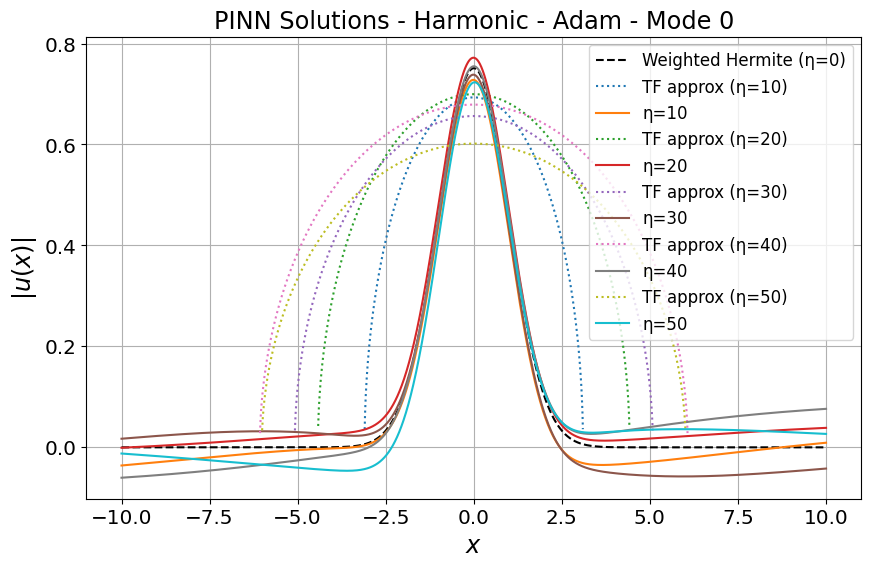

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 18.829569, Loss: 19092.757812
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 5.405858, Loss: 171.978500
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 4.809986, Loss: 40.062450
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 18.830353, Loss: 65775.289062
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 25.601082, Loss: 7700.943848
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 22.777096, Loss: 52.263168
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 44.171135, Loss: 5516.678711
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 36.270966, Loss: 107.594658
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 15.802270, Loss: 0.061719
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 41.660042, Loss: 2313.041016
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 27.343428, Loss: 116.354057
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 10.629954, Loss: 4.402717
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 41.214005, Loss: 14025.915039
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 10.260291, Loss: 164.014725
[A

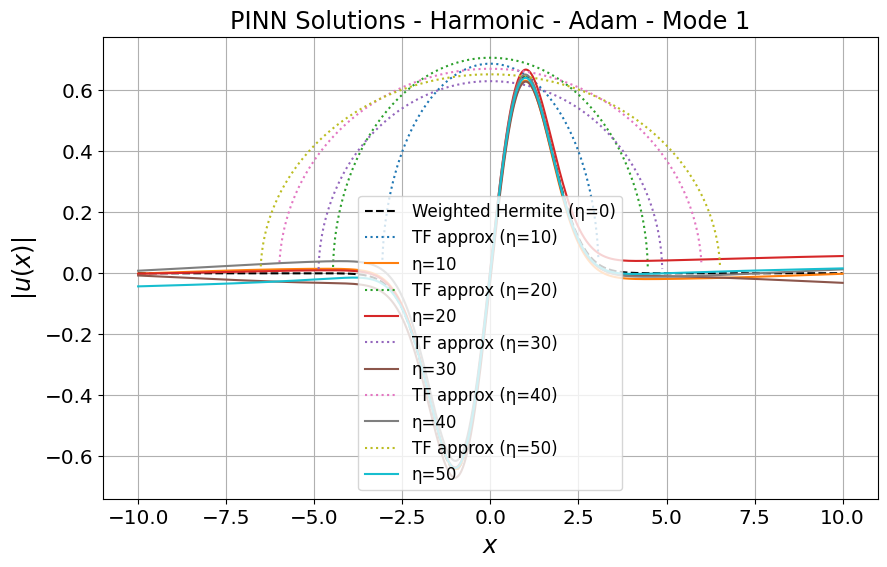

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 24.296970, Loss: 3478.894531
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 16.778097, Loss: 2182.878174
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 5.896123, Loss: 0.083759
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 13.835168, Loss: 109613.835938
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 13.611223, Loss: 13.599299
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 20.351202, Loss: 0.246589
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 34.108315, Loss: 66925.492188
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 25.343031, Loss: 2048.979980
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 23.694778, Loss: 772.059082
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 49.034435, Loss: 3625.299072
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 14.659953, Loss: 9.112815
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 14.742000, Loss: 8.802104
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 54.103024, Loss: 20.251835
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 27.134550, Loss: 619.252502
[Adam

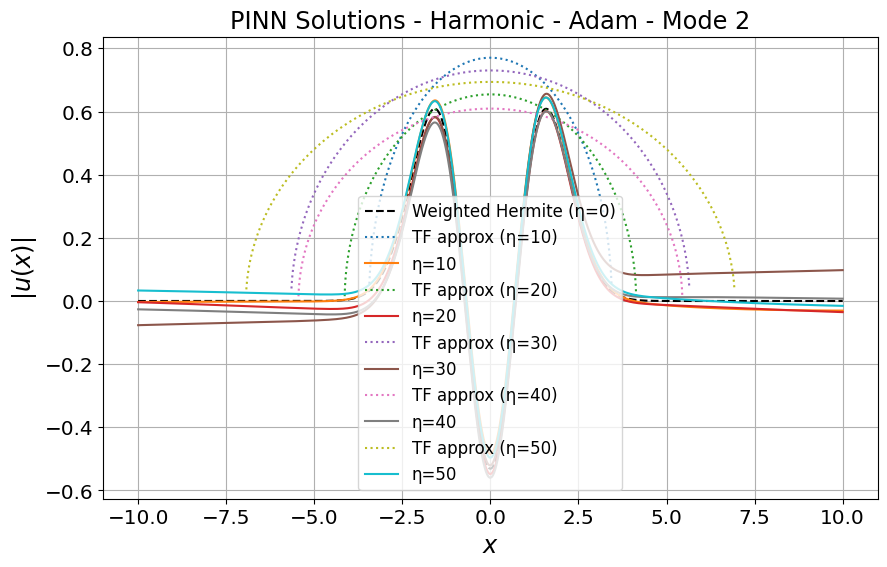

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 7.368112, Loss: 88518.171875
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 13.568101, Loss: 1076.307495
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 5.608590, Loss: 56.565300
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 30.988037, Loss: 28336.128906
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 22.125282, Loss: 550.074829
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 15.735549, Loss: 0.901923
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 37.070545, Loss: 2945.487305
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 25.364441, Loss: 503.149689
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 21.834011, Loss: 1.602198
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 29.165533, Loss: 61989.316406
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 29.841272, Loss: 1141.607056
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 20.167377, Loss: 88.199928
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 37.558632, Loss: 19047.388672
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 20.795130, Loss: 1.330638
[A

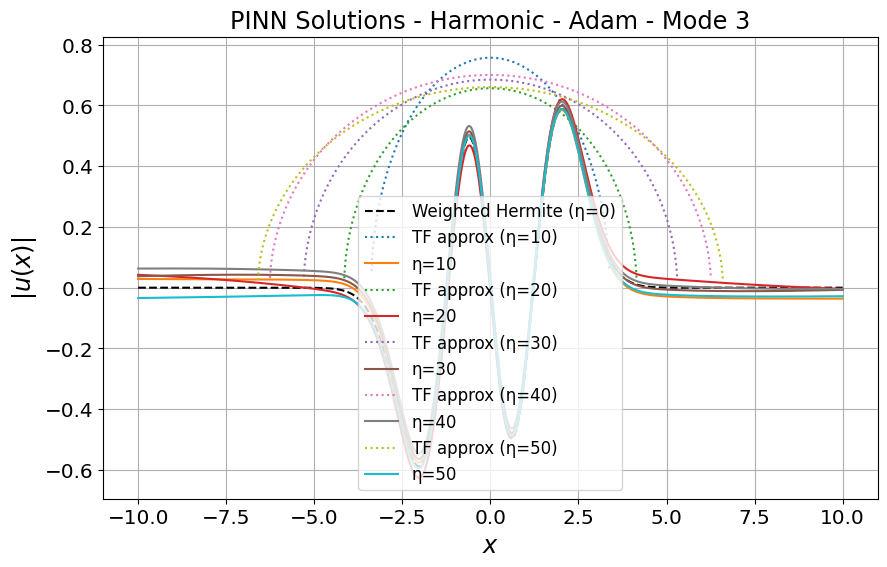

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 30.073027, Loss: 6461.523438
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 12.575120, Loss: 746.765625
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 5.501520, Loss: 0.387665
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 25.909946, Loss: 216365.515625
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 14.695373, Loss: 1.851376
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 37.193172, Loss: 16.164766
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 30.387936, Loss: 27601.521484
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 33.079678, Loss: 3994.365479
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 20.967632, Loss: 0.239942
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 31.793163, Loss: 38500.683594
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 25.410736, Loss: 1182.865479
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 18.705685, Loss: 2.031977
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 37.243114, Loss: 17481.755859
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 12.591235, Loss: 3.751966
[Ad

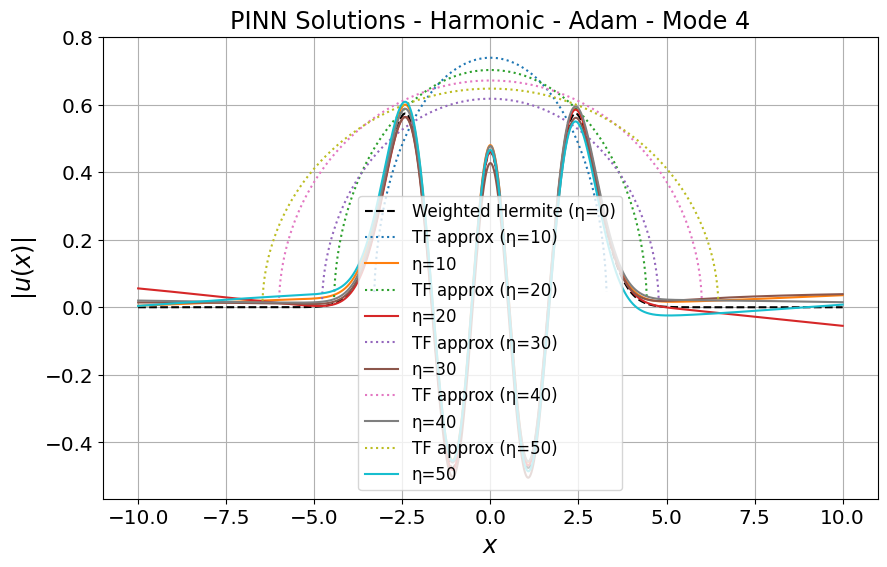

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 28.959885, Loss: 21.384565
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 12.204664, Loss: 1539.452393
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 6.079968, Loss: 34.340271
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 34.171417, Loss: 5014.922363
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 20.464083, Loss: 437.660889
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 21.668854, Loss: 0.395669
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 37.818508, Loss: 1915.415527
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 23.501837, Loss: 1899.812378
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 9.542253, Loss: 8.641714
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 30.666124, Loss: 86796.484375
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 31.282089, Loss: 36.846611
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 14.422796, Loss: 0.155011
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 38.554859, Loss: 12392.912109
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 33.062691, Loss: 36.711494
[Adam] 

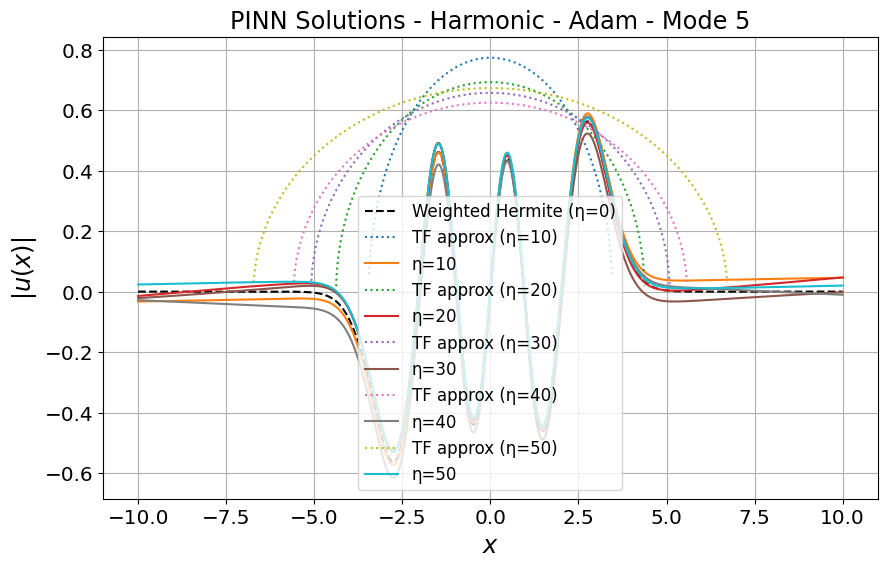

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 29.960831, Loss: 406.462921
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 28.727715, Loss: 13195.163086
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 5.315624, Loss: 0.797066
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 32.651127, Loss: 9106.123047
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 27.720224, Loss: 2091.615479
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 15.802367, Loss: 0.208704
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 34.203442, Loss: 3969.117188
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 23.160851, Loss: 235.693634
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 15.465932, Loss: 0.962744
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 41.322704, Loss: 5186.522949
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 28.972954, Loss: 83.715530
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 24.773691, Loss: 16.277554
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 38.983059, Loss: 352450.281250
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 13.515998, Loss: 165.834869
[Ad

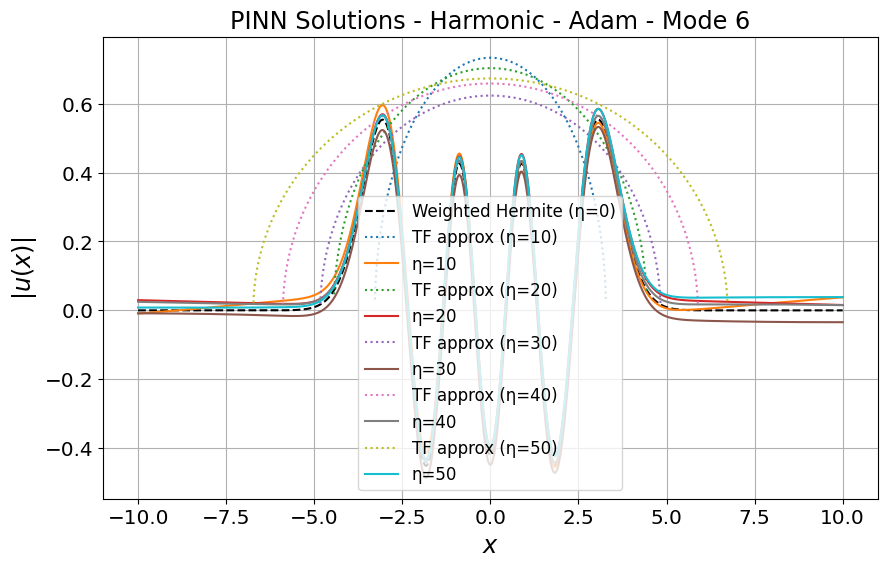

Training with Adam optimizer...
[Adam] Epoch [0/2001]: η = 10, λ_PDE = 26.317066, Loss: 652.562683
[Adam] Epoch [1000/2001]: η = 10, λ_PDE = 5.197235, Loss: 308.802124
[Adam] Epoch [2000/2001]: η = 10, λ_PDE = 4.933905, Loss: 3.305702
[Adam] Epoch [0/2001]: η = 20, λ_PDE = 28.626852, Loss: 16101.795898
[Adam] Epoch [1000/2001]: η = 20, λ_PDE = 31.378521, Loss: 5315.772461
[Adam] Epoch [2000/2001]: η = 20, λ_PDE = 8.487015, Loss: 2.520277
[Adam] Epoch [0/2001]: η = 30, λ_PDE = 10.488078, Loss: 88904.312500
[Adam] Epoch [1000/2001]: η = 30, λ_PDE = 11.826837, Loss: 9.461632
[Adam] Epoch [2000/2001]: η = 30, λ_PDE = 28.029503, Loss: 156.676224
[Adam] Epoch [0/2001]: η = 40, λ_PDE = 42.811779, Loss: 7044.414062
[Adam] Epoch [1000/2001]: η = 40, λ_PDE = 12.309677, Loss: 115.018135
[Adam] Epoch [2000/2001]: η = 40, λ_PDE = 9.056703, Loss: 7.455660
[Adam] Epoch [0/2001]: η = 50, λ_PDE = 47.027882, Loss: 5768.037109
[Adam] Epoch [1000/2001]: η = 50, λ_PDE = 19.582466, Loss: 970.730042
[Adam] E

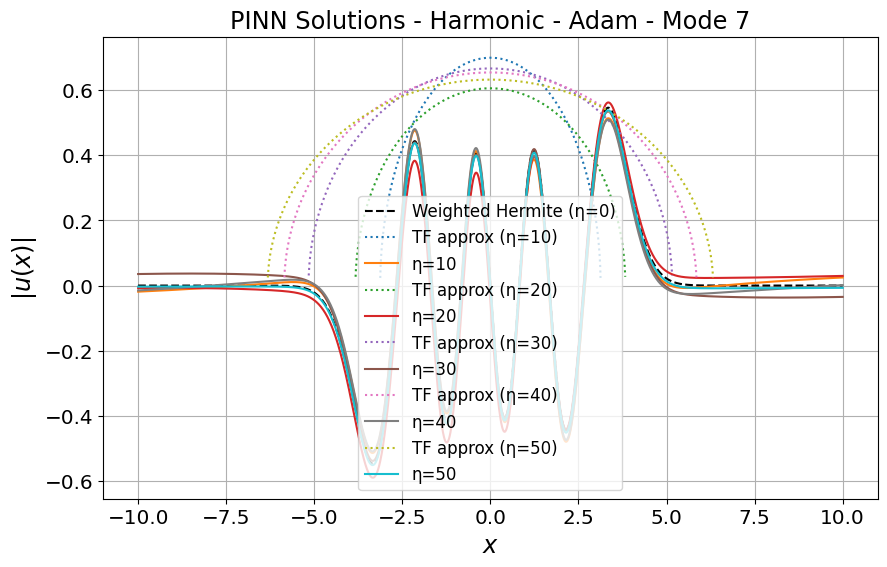

In [14]:
#potential_types = ['gaussian', 'double_well', 'harmonic', 'periodic']
potential_types = ['harmonic']

# Optimizers to compare
optimizer_names = ["Adam"]
# optimizer_names = ["Adam"]

# Modes for ground state solution to Gross-Pitavskii equation
modes = [0, 1, 2, 3, 4, 5, 6, 7]

# Store results for plotting
all_loss_histories = {}
all_lambda_pde_histories = {}
models = {eta: {} for eta in etas}  # Store models for all η and optimizers

# Loop through every mode
for mode in modes:

    # Loop through each potential type
    for potential_type in potential_types:

        for optimizer_name in optimizer_names:
            print(f"Training with {optimizer_name} optimizer...")

            # Store results for each optimizer separately
            prev_model = None
            loss_histories = {}
            lambda_pde_histories = {}

            for eta in etas:
                model_save_path = f"trained_model_eta_{eta}_{optimizer_name}.pth"
                model, loss_history, lambda_pde_history = train_and_save_pinn(X, N_u=N_u, N_f=N_f, layers=layers, eta=eta,
                                                                              epochs=epochs, lb=lb, ub=ub,
                                                                              weights=weights, model_save_path=model_save_path,
                                                                              potential_type=potential_type, prev_model=prev_model,
                                                                              optimizer_name=optimizer_name, mode=mode)
                # Store the trained model for the next iteration
                prev_model = model

                # Store models by eta and optimizer
                models[eta][optimizer_name] = model

                # Store loss and λ_PDE history under each eta for this optimizer
                if potential_type not in all_loss_histories:
                    all_loss_histories[potential_type] = {}
                if potential_type not in all_lambda_pde_histories:
                    all_lambda_pde_histories[potential_type] = {}

                all_loss_histories[potential_type].setdefault(eta, {})[optimizer_name] = loss_history
                all_lambda_pde_histories[potential_type].setdefault(eta, {})[optimizer_name] = lambda_pde_history

        # Predict and plot the solutions for each optimizer separately
        predict_and_plot(models, etas, optimizer_names, mode, X_test, save_path='plots/predicted_solutions_{potential_type}.png',
                         potential_type=potential_type, prev_prediction=prev_model)

        # # Plot the loss history for all etas
        # plot_loss_history(all_loss_histories[potential_type], etas, optimizer_names,
        #                   save_path='plots/loss_history_{potential_type}.png', potential_type=potential_type)
        #
        # # Plot lambda_pde history for all etas
        # plot_lambda_pde(all_lambda_pde_histories[potential_type], etas, optimizer_names,
        #                 save_path=f'plots/lambda_pde_{potential_type}.png', potential_type=potential_type)